In [1]:
import matplotlib.pyplot as plt
import json

In [21]:
import numpy as np
import matplotlib.pyplot as plt

'''DEFINE THE FIGURE AND DOMAIN'''
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
'''FANCY PREAMBLE TO MAKE BRAKET PACKAGE WORK NICELY'''
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{braket}')

In [9]:
with open("data/Toy_SGD_lr=1_Bitflip=0.05_v2.json", "r") as f:
    data = json.load(f)

In [10]:
data[-1]

{'problem': 'ToyProblem',
 'trial': 9,
 'n_qubits': 6,
 'ansatz': '2-layer HEA',
 'cost': 'local',
 'optimizer': 'SGD_lr=1',
 'error_threshold': 0.0016,
 'noise_model': 'Bitflip=0.05',
 'TTS': 24529.556998729706,
 'STS': 762,
 'final_EAD': 0.004718539017332884,
 'EAD_history': [3.1590916750170166,
  0.5662350449547813,
  0.2746954165421529,
  0.1389781313756877,
  0.0899299654478063,
  0.05472029266156907,
  0.0322593977464949,
  0.022180152054919716,
  0.018031231272781365,
  0.015948194557004716,
  0.011816514785741805,
  0.009829064047699596,
  0.01096167764128414,
  0.007723029676138299,
  0.006108671490734115,
  0.005660206761862758,
  0.008905736253701488,
  0.0067202065448574615,
  0.005200329020505972,
  0.005878161361158483,
  0.0062037502168915395,
  0.008033561993336156,
  0.005862256422649294,
  0.004657670207222697,
  0.005817837672746542,
  0.006006143655844995,
  0.006115005817585077,
  0.005973020303970466,
  0.005111497849694172,
  0.00789656659936082,
  0.005807114438

In [11]:
# fig, (ax1) = plt.subplots(1)

# x_labels = ["Noiseless", "5% Bitflip error", "FakeManila"]
# y_vals = [5,5,0]

# ax1.bar(x_labels, y_vals, color='skyblue')

# # Adding title and labels
# plt.title('Max implementation on different backends')
# plt.xlabel('Type of backend')
# plt.ylabel('Max qubits ran')

# plt.savefig("images/max_imp.png")

In [12]:
# import numpy as np

# noiseless_data = data[-1]
# x1 = range(6, noiseless_data["STS"]+1)
# y1 = noiseless_data["cost_history"][5:]


# x2 = np.linspace(1, noiseless_data["STS"], len(noiseless_data["EAD_history"]) - 5)
# y2 = noiseless_data["EAD_history"][5:]

# fig, (ax1) = plt.subplots(1)

# ax1.plot(x1, y1, label="cost history", color="black")
# # ax1.scatter(x2, y2, label="Solution quality", color="red")
# ax1.plot(x2, y2, label="Solution quality", color="red")

# # Adding title and labels
# plt.title('Cost function and solution quality for 2-qubit FakeManila run')
# plt.xlabel('# iterations')
# plt.ylabel('Value')
# plt.legend()

# plt.savefig("fakemanila_cost+sol.png")

In [13]:
with open("data/Toy_SGD_lr=1_Bitflip=0.05_v2.json", "r") as f:
    data = json.load(f)

In [14]:
from collections import defaultdict
import numpy as np
d = defaultdict(lambda: defaultdict(list))

for trial in data:
    d[trial["n_qubits"]]["STS"].append(trial["STS"])

In [15]:
means = []
stds = []
for n_qubits in d.keys():
    means.append(np.mean(d[n_qubits]["STS"]))
    stds.append(np.std(d[n_qubits]["STS"]))

In [22]:
print(means[:-1])

# Plotting
fig, ax = plt.subplots()

# Bar for mean
ax.bar([2,3,4,5], means[:-1], yerr=stds[:-1], align='center', alpha=0.5, ecolor='black', capsize=10, label='Mean ± SEM')

ax.set_xticks([2,3,4,5])
# Adding labels and title
ax.set_xlabel('Number of qubits')
ax.set_ylabel('Steps to Solution')
# ax.set_title('average STS vs. number of qubits (Noiseless)')
ax.set_title('average STS vs. number of qubits (5% Bitflip error)')

# plt.savefig('images/noiseless_STS.png')
plt.savefig('images/Bitflip_STS.png')

[28.0, 29.0, 115.0, 170.0]


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

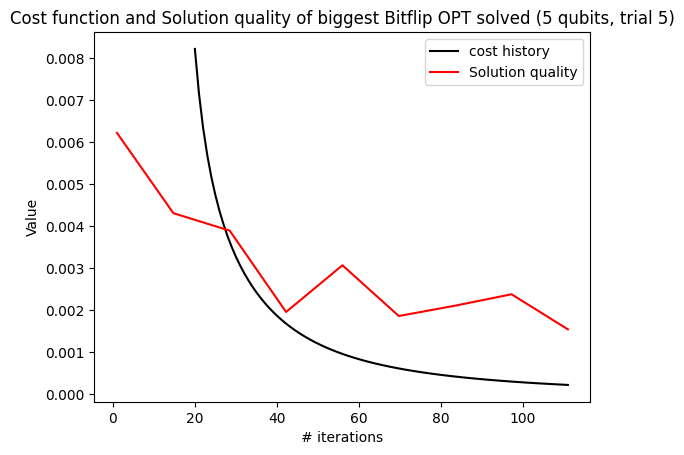

In [23]:
import numpy as np

noiseless_data = data[-6]
x1 = range(20, noiseless_data["STS"]+1)
y1 = noiseless_data["cost_history"][19:]


x2 = np.linspace(1, noiseless_data["STS"], len(noiseless_data["EAD_history"]) - 3)
y2 = noiseless_data["EAD_history"][3:]

fig, (ax1) = plt.subplots(1)

ax1.plot(x1, y1, label="cost history", color="black")
# ax1.scatter(x2, y2, label="Solution quality", color="red")
ax1.plot(x2, y2, label="Solution quality", color="red")

# Adding title and labels
plt.title('Cost function and Solution quality of biggest Bitflip OPT solved (5 qubits, trial 5)')
plt.xlabel('# iterations')
plt.ylabel('Value')
plt.legend()

plt.savefig("bitflip=0.05_cost+sol.png")

In [17]:
with open("data/Toy_SGD_lr=1_None_v2.json", "r") as f:
    data = json.load(f)

In [18]:
means = []
stds = []
for n_qubits in d.keys():
    means.append(np.mean(d[n_qubits]["STS"]))
    stds.append(np.std(d[n_qubits]["STS"]))

[28.0, 29.0, 115.0, 170.0]


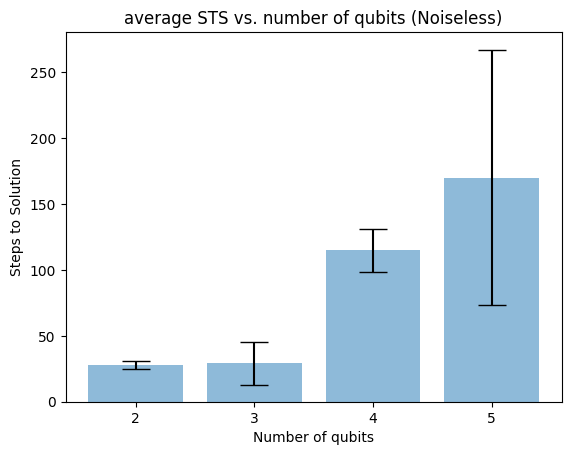

In [19]:
print(means[:-1])

# Plotting
fig, ax = plt.subplots()

# Bar for mean
ax.bar([2,3,4,5], means[:-1], yerr=stds[:-1], align='center', alpha=0.5, ecolor='black', capsize=10, label='Mean ± SEM')

ax.set_xticks([2,3,4,5])
# Adding labels and title
ax.set_xlabel('Number of qubits')
ax.set_ylabel('Steps to Solution')
# ax.set_title('average STS vs. number of qubits (Noiseless)')
ax.set_title('average STS vs. number of qubits (Noiseless)')

# plt.savefig('images/noiseless_STS.png')
plt.savefig('images/noiseless_STS.png')

In [7]:
data[-12]

{'problem': 'ToyProblem',
 'trial': 4,
 'n_qubits': 5,
 'ansatz': '2-layer HEA',
 'cost': 'local',
 'optimizer': 'SGD_lr=1',
 'error_threshold': 0.0016,
 'noise_model': None,
 'TTS': 1856.9859759807587,
 'STS': 306,
 'final_EAD': 0.0013479701842330882,
 'EAD_history': [2.4742353490195805,
  0.7144336735561709,
  0.41470835510458454,
  0.2756511282672339,
  0.18738228368634838,
  0.1274645504339598,
  0.09580898055823132,
  0.06619703509950316,
  0.04400359661962336,
  0.03113469714095298,
  0.023186397065027804,
  0.018713205342990737,
  0.01339420528648055,
  0.012562125428377596,
  0.012650542355966587,
  0.008665110640266092,
  0.010477511585209955,
  0.00628281526951783,
  0.008553082170579698,
  0.006721513181218231,
  0.008406912082036292,
  0.007099649492910774,
  0.005342756742680682,
  0.004188855820032176,
  0.006537433056297383,
  0.004546924728753339,
  0.004193768199489068,
  0.0042737257872381635,
  0.003480784517458402,
  0.004849301443231719,
  0.003638097139368296,
  0

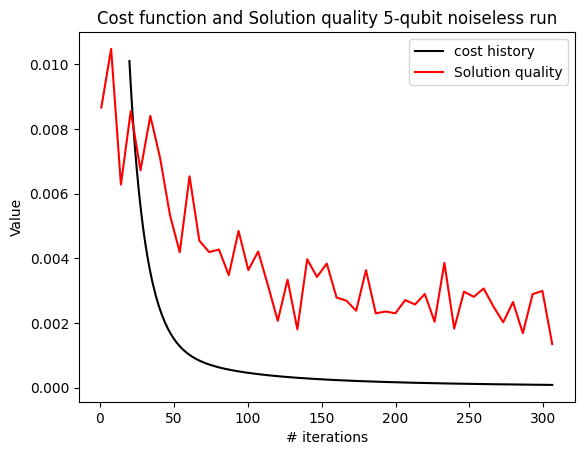

In [9]:
import numpy as np

noiseless_data = data[-12]
x1 = range(20, noiseless_data["STS"]+1)
y1 = noiseless_data["cost_history"][19:]


x2 = np.linspace(1, noiseless_data["STS"], len(noiseless_data["EAD_history"]) - 15)
y2 = noiseless_data["EAD_history"][15:]

fig, (ax1) = plt.subplots(1)

ax1.plot(x1, y1, label="cost history", color="black")
# ax1.scatter(x2, y2, label="Solution quality", color="red")
ax1.plot(x2, y2, label="Solution quality", color="red")

# Adding title and labels
plt.title('Cost function and Solution quality 5-qubit noiseless run')
plt.xlabel('# iterations')
plt.ylabel('Value')
plt.legend()

plt.savefig("noiseless_cost+sol.png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

'''DEFINE THE FIGURE AND DOMAIN'''
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
'''FANCY PREAMBLE TO MAKE BRAKET PACKAGE WORK NICELY'''
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{braket}')


def GET_PLOT1(guessqubits, barray=bdl_array, NMODELS=["bitflippenny=0.05", 'nonoise', "FakeManila"],  numpoints=6, HPREF='XX',ifsave=False, bar_labels = ['red'], bar_colors = ['tab:red']):
    best_instances=np.zeros([len(guessqubits)])

    for m, qubits in enumerate(guessqubits):
        if NMODELS[m]=='nonoise':
            Z=Z_FCN(np.array([qubits]),barray, NMODELS[m], numpoints=6,HPREF='XX', noisy=False)
        else:
            Z=Z_FCN_BEST(np.array([qubits]),barray, NMODELS[m], numpoints,HPREF=HPREF, noisy=True)
        
        if len(Z[np.where(Z==1)])==0:
            print('Warning, no AAVQE best solution found for this noise model and'+str(qubits)+' qubits')
    
    plt.bar(NMODELS, guessqubits, label=bar_labels, color=bar_colors)       
    plt.ylabel('number of qubits')
    plt.xlabel('noise models')
    
    if ifsave==True:
        SAVE_PLOT('AAVQE_max_implementation.pdf')
    plt.show()
